In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import eig
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv('surgical_equipment_supplier_selection.csv')
print(f"Loaded data with {len(df)} suppliers")
print(df.head())

Loaded data with 100 suppliers
      Supplier            Product  Cost per Unit (INR)  Quality (1-10)  \
0  MedSupply_1           Scalpels                 2555               5   
1  MedSupply_2           Scalpels                 1776               5   
2  MedSupply_3  Surgical Scissors                 3266               7   
3  MedSupply_4     Needle Holders                  802               7   
4  MedSupply_5     Needle Holders                 1138               5   

   Delivery Time (Days)  Reliability (1-10)  Flexibility (1-10)  \
0                     2                   6                   8   
1                     5                   8                   5   
2                     4                   8                   6   
3                     5                   9                   7   
4                     5                   9                   5   

   Regulatory Compliance (1-10)  Sterility Standards (1-10)  \
0                             8                           

In [5]:
# Extract criteria columns (excluding Supplier and Product)
criteria_cols = df.columns[2:].tolist()
print(f"\nCriteria columns: {criteria_cols}")


Criteria columns: ['Cost per Unit (INR)', 'Quality (1-10)', 'Delivery Time (Days)', 'Reliability (1-10)', 'Flexibility (1-10)', 'Regulatory Compliance (1-10)', 'Sterility Standards (1-10)', 'After-Sales Support (1-10)']


In [7]:
# Example pairwise comparison matrix (we'll use this to determine criteria weights)
# The matrix shows how important each criterion is compared to others
# Scale: 1=equal, 3=moderate, 5=strong, 7=very strong, 9=extreme importance
# For this example, I'm creating a sample comparison matrix
# In real-world applications, this would come from expert judgments

# Criteria order: Cost, Quality, Delivery Time, Reliability, Flexibility,
#                Regulatory Compliance, Sterility Standards, After-Sales Support
comparison_matrix = np.array([
    [1.0, 1/3, 2.0, 1/4, 3.0, 1/5, 1/7, 1.0],  # Cost
    [3.0, 1.0, 4.0, 1/2, 5.0, 1/3, 1/4, 2.0],  # Quality
    [1/2, 1/4, 1.0, 1/5, 2.0, 1/6, 1/8, 1/2],  # Delivery Time
    [4.0, 2.0, 5.0, 1.0, 6.0, 1/2, 1/3, 3.0],  # Reliability
    [1/3, 1/5, 1/2, 1/6, 1.0, 1/7, 1/9, 1/4],  # Flexibility
    [5.0, 3.0, 6.0, 2.0, 7.0, 1.0, 1/2, 4.0],  # Regulatory Compliance
    [7.0, 4.0, 8.0, 3.0, 9.0, 2.0, 1.0, 6.0],  # Sterility Standards
    [1.0, 1/2, 2.0, 1/3, 4.0, 1/4, 1/6, 1.0]   # After-Sales Support
])

print("\nPairwise comparison matrix:")
np.set_printoptions(precision=2)
print(comparison_matrix)


Pairwise comparison matrix:
[[1.   0.33 2.   0.25 3.   0.2  0.14 1.  ]
 [3.   1.   4.   0.5  5.   0.33 0.25 2.  ]
 [0.5  0.25 1.   0.2  2.   0.17 0.12 0.5 ]
 [4.   2.   5.   1.   6.   0.5  0.33 3.  ]
 [0.33 0.2  0.5  0.17 1.   0.14 0.11 0.25]
 [5.   3.   6.   2.   7.   1.   0.5  4.  ]
 [7.   4.   8.   3.   9.   2.   1.   6.  ]
 [1.   0.5  2.   0.33 4.   0.25 0.17 1.  ]]


In [9]:
### AHP Implementation ###

def normalize_column(matrix, col_idx):
    """Normalize a column of the pairwise comparison matrix"""
    col_sum = np.sum(matrix[:, col_idx])
    return matrix[:, col_idx] / col_sum

In [11]:
def calculate_priority_vector(comparison_matrix):
    """Calculate the priority vector (eigenvector) from the pairwise comparison matrix"""
    n = len(comparison_matrix)
    # Normalize each column
    normalized_matrix = np.zeros_like(comparison_matrix, dtype=float)
    for i in range(n):
        normalized_matrix[:, i] = normalize_column(comparison_matrix, i)
    
    # Calculate row averages to get the priority vector
    priority_vector = np.mean(normalized_matrix, axis=1)
    
    return priority_vector

In [21]:
def calculate_consistency_ratio(comparison_matrix, priority_vector):
    """Calculate the consistency ratio to check if comparisons are consistent"""
    n = len(comparison_matrix)
    # Calculate λmax (principal eigenvalue)
    weighted_sum = np.dot(comparison_matrix, priority_vector)
    consistency_vector = weighted_sum / priority_vector
    lambda_max = np.mean(consistency_vector)
    
    # Calculate Consistency Index (CI)
    CI = (lambda_max - n) / (n - 1)
    
    # Random Consistency Index (RI) values for different matrix sizes
    RI_values = {1: 0, 2: 0, 3: 0.58, 4: 0.9, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49}
    RI = RI_values.get(n, 1.5)  # Default to 1.5 for larger matrices

    # Calculate Consistency Ratio (CR)
    CR = CI / RI
    
    return CR, lambda_max

In [23]:
# Calculate priority vector (criteria weights)
criteria_weights = calculate_priority_vector(comparison_matrix)
criteria_weights = criteria_weights / np.sum(criteria_weights)  # Ensure it sums to 1

print("\nCriteria weights:")
for i, criterion in enumerate(criteria_cols):
    print(f"{criterion}: {criteria_weights[i]:.4f}")


Criteria weights:
Cost per Unit (INR): 0.0518
Quality (1-10): 0.1061
Delivery Time (Days): 0.0341
Reliability (1-10): 0.1546
Flexibility (1-10): 0.0234
Regulatory Compliance (1-10): 0.2245
Sterility Standards (1-10): 0.3445
After-Sales Support (1-10): 0.0609


In [25]:
# Check consistency
CR, lambda_max = calculate_consistency_ratio(comparison_matrix, criteria_weights)
print(f"\nConsistencyc Ratio: {CR:.4f}")
if CR < 0.1:
    print("The pairwise comparisons are consistent (CR < 0.1)")
else:
    print("Warning: The pairwise comparisons are inconsistent (CR >= 0.1)")
    print("Consider revising the comparison matrix")


Consistencyc Ratio: 0.0234
The pairwise comparisons are consistent (CR < 0.1)


In [27]:
### TOPSIS Implementation ###

def topsis(decision_matrix, weights, criteria_types):
    """
    Implement TOPSIS method
    
    Parameters:
    decision_matrix: numpy array of alternatives x criteria
    weights: criteria weights (from AHP)
    criteria_types: list of benefit (+1) or cost (-1) for each criterion
    
    Returns:
    ranking: indices of alternatives sorted by preference
    """
    # Step 1: Normalize the decision matrix
    # Using vector normalization method
    norm_matrix = np.zeros_like(decision_matrix, dtype=float)
    for j in range(decision_matrix.shape[1]):
        norm_matrix[:, j] = decision_matrix[:, j] / np.sqrt(np.sum(decision_matrix[:, j]**2))
    
    # Step 2: Calculate the weighted normalized decision matrix
    weighted_norm_matrix = norm_matrix * weights
    
    # Step 3: Determine the ideal and negative-ideal solutions
    ideal_best = np.zeros(decision_matrix.shape[1])
    ideal_worst = np.zeros(decision_matrix.shape[1])
    
    for j in range(decision_matrix.shape[1]):
        if criteria_types[j] == 1:  # Benefit criterion (higher is better)
            ideal_best[j] = np.max(weighted_norm_matrix[:, j])
            ideal_worst[j] = np.min(weighted_norm_matrix[:, j])
        else:  # Cost criterion (lower is better)
            ideal_best[j] = np.min(weighted_norm_matrix[:, j])
            ideal_worst[j] = np.max(weighted_norm_matrix[:, j])
    
    # Step 4: Calculate separation measures
    separation_best = np.sqrt(np.sum((weighted_norm_matrix - ideal_best)**2, axis=1))
    separation_worst = np.sqrt(np.sum((weighted_norm_matrix - ideal_worst)**2, axis=1))
    
    # Step 5: Calculate relative closeness to the ideal solution
    relative_closeness = separation_worst / (separation_best + separation_worst)
    
    # Step 6: Rank the alternatives
    ranking = np.argsort(relative_closeness)[::-1]  # Descending order
    
    return ranking, relative_closeness

In [21]:
# Prepare data for TOPSIS
# Extract the decision matrix (all alternatives and criteria)
decision_matrix = df[criteria_cols].values

# Define criteria types: benefit (+1) or cost (-1)
# Cost (-1): Cost per Unit, Delivery Time (lower is better)
# Benefit (+1): All others (higher is better)
criteria_types = [-1, 1, -1, 1, 1, 1, 1, 1]

In [23]:
# Apply TOPSIS
ranking_indices, closeness_values = topsis(decision_matrix, criteria_weights, criteria_types)

# Create results DataFrame
results = pd.DataFrame({
    'Supplier': df['Supplier'].values,
    'Product': df['Product'].values,
    'Closeness to Ideal': closeness_values,
    'Rank': np.argsort(ranking_indices) + 1  # Convert to ranks (1-based)
})

In [25]:
# Sort by rank
results = results.sort_values('Rank')

print("\nTop 10 suppliers based on TOPSIS:")
print(results.head(10))

# Analyze results by product category
product_categories = df['Product'].unique()
top_suppliers_by_category = {}



Top 10 suppliers based on TOPSIS:
        Supplier            Product  Closeness to Ideal  Rank
46  MedSupply_47            Forceps            0.780620     1
98  MedSupply_99           Scalpels            0.744928     2
58  MedSupply_59  Surgical Scissors            0.731796     3
74  MedSupply_75  Surgical Scissors            0.725243     4
50  MedSupply_51         Retractors            0.720260     5
91  MedSupply_92  Surgical Scissors            0.715151     6
3    MedSupply_4     Needle Holders            0.711451     7
83  MedSupply_84     Needle Holders            0.708140     8
95  MedSupply_96           Scalpels            0.706797     9
10  MedSupply_11            Forceps            0.697253    10


In [27]:
for product in product_categories:
    product_results = results[results['Product'] == product].copy()
    product_results = product_results.sort_values('Rank')
    top_suppliers_by_category[product] = product_results.head(3)
    print(f"\nTop 3 suppliers for {product}:")
    print(top_suppliers_by_category[product])


Top 3 suppliers for Scalpels:
        Supplier   Product  Closeness to Ideal  Rank
98  MedSupply_99  Scalpels            0.744928     2
95  MedSupply_96  Scalpels            0.706797     9
1    MedSupply_2  Scalpels            0.684419    12

Top 3 suppliers for Surgical Scissors:
        Supplier            Product  Closeness to Ideal  Rank
58  MedSupply_59  Surgical Scissors            0.731796     3
74  MedSupply_75  Surgical Scissors            0.725243     4
91  MedSupply_92  Surgical Scissors            0.715151     6

Top 3 suppliers for Needle Holders:
        Supplier         Product  Closeness to Ideal  Rank
3    MedSupply_4  Needle Holders            0.711451     7
83  MedSupply_84  Needle Holders            0.708140     8
4    MedSupply_5  Needle Holders            0.641122    20

Top 3 suppliers for Retractors:
        Supplier     Product  Closeness to Ideal  Rank
50  MedSupply_51  Retractors            0.720260     5
5    MedSupply_6  Retractors            0.696727    1

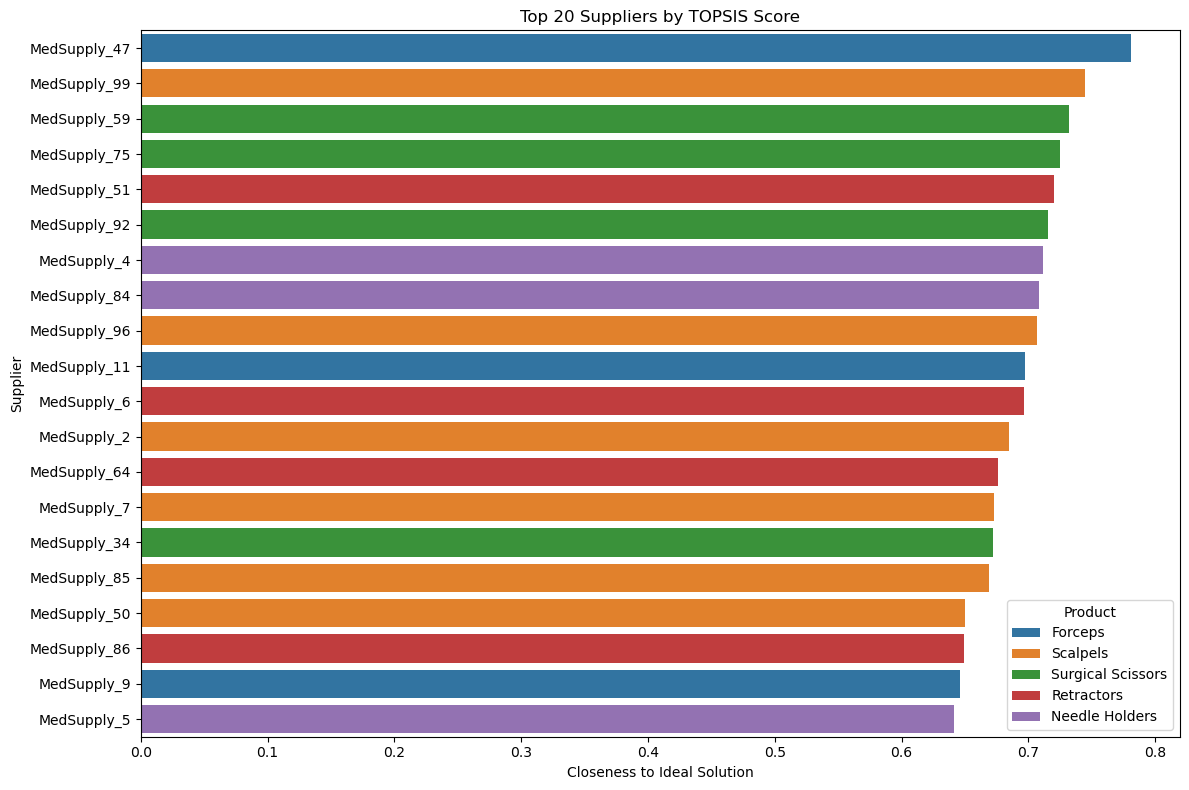

In [29]:
# Visualize results
plt.figure(figsize=(12, 8))
sns.barplot(x='Closeness to Ideal', y='Supplier', data=results.head(20), hue='Product', dodge=False)
plt.title('Top 20 Suppliers by TOPSIS Score')
plt.xlabel('Closeness to Ideal Solution')
plt.ylabel('Supplier')
plt.tight_layout()
plt.savefig('top_suppliers_ranking.png')


In [31]:
# Analysis of criteria contribution for top suppliers
top_10_suppliers = results.head(10)['Supplier'].values
top_10_data = df[df['Supplier'].isin(top_10_suppliers)]

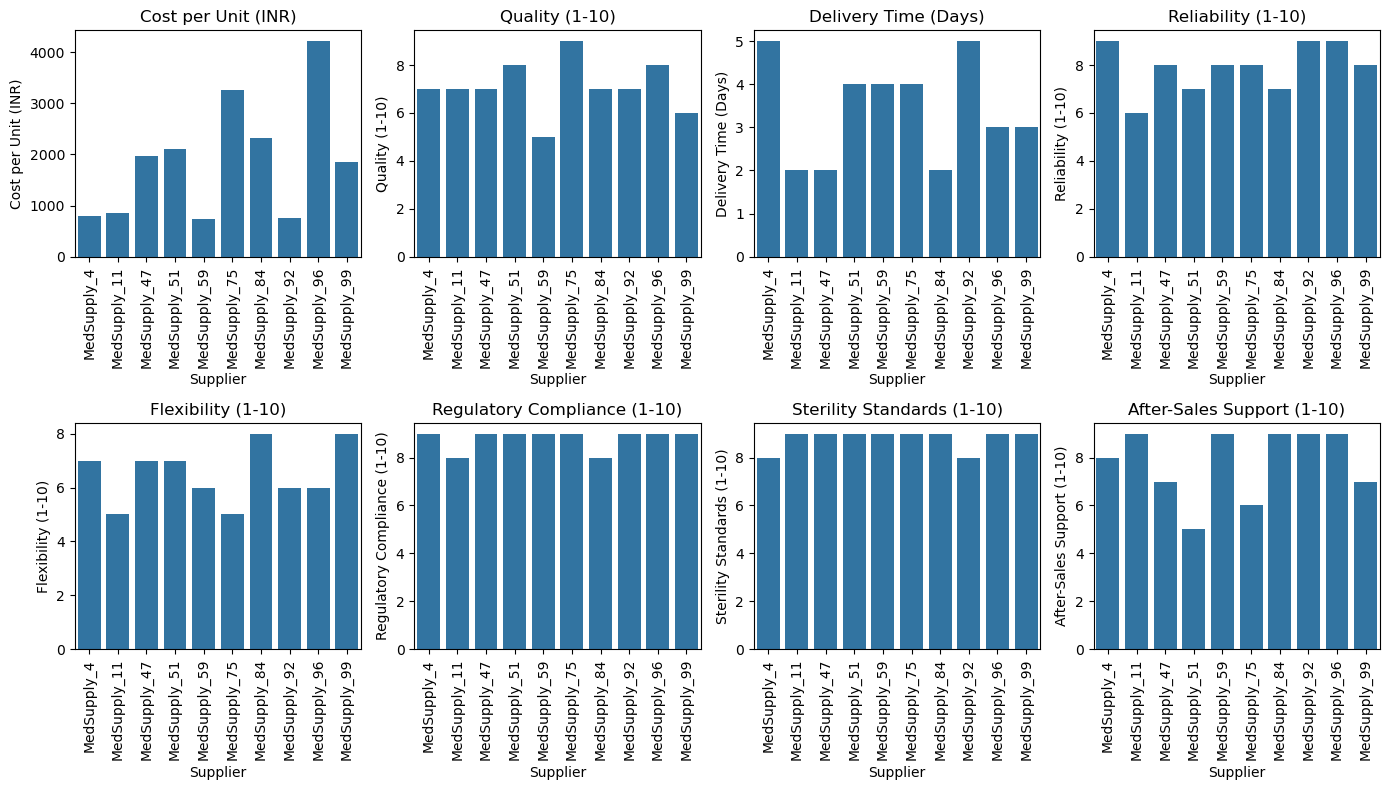

In [33]:
plt.figure(figsize=(14, 8))
for i, criterion in enumerate(criteria_cols):
    plt.subplot(2, 4, i+1)
    sns.barplot(x='Supplier', y=criterion, data=top_10_data)
    plt.title(f'{criterion}')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('top_suppliers_criteria_comparison.png')

In [34]:
# Sensitivity analysis - modify weights and observe changes
def perform_sensitivity_analysis(decision_matrix, original_weights, criteria_types):
    """Perform sensitivity analysis by varying each criterion weight"""
    n_criteria = len(original_weights)
    n_alternatives = len(decision_matrix)
    
    # Variations to test (±10%, ±20%, ±30%)
    variations = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
    
    sensitivity_results = {}
    
    for i in range(n_criteria):
        criterion_results = []
        
        for var in variations:
            # Create modified weights
            modified_weights = original_weights.copy()
            modified_weights[i] = original_weights[i] * var
            # Normalize to sum to 1
            modified_weights = modified_weights / np.sum(modified_weights)
            
            # Apply TOPSIS with modified weights
            _, closeness = topsis(decision_matrix, modified_weights, criteria_types)
            
            # Get top 3 alternatives
            top3_indices = np.argsort(closeness)[::-1][:3]
            
            criterion_results.append(top3_indices)
        
        sensitivity_results[criteria_cols[i]] = criterion_results
    
    return sensitivity_results


In [37]:
# Run sensitivity analysis
sensitivity_results = perform_sensitivity_analysis(decision_matrix, criteria_weights, criteria_types)


In [39]:
# Report on stability of rankings
print("\nSensitivity Analysis Summary:")
for criterion, variations in sensitivity_results.items():
    # Check if top supplier changes across variations
    top_suppliers = [var[0] for var in variations]
    if len(set(top_suppliers)) == 1:
        stability = "Very stable"
    elif len(set(top_suppliers)) <= 2:
        stability = "Mostly stable"
    else:
        stability = "Sensitive"
    
    print(f"{criterion}: Ranking is {stability} to weight changes")




Sensitivity Analysis Summary:
Cost per Unit (INR): Ranking is Very stable to weight changes
Quality (1-10): Ranking is Very stable to weight changes
Delivery Time (Days): Ranking is Very stable to weight changes
Reliability (1-10): Ranking is Very stable to weight changes
Flexibility (1-10): Ranking is Very stable to weight changes
Regulatory Compliance (1-10): Ranking is Very stable to weight changes
Sterility Standards (1-10): Ranking is Very stable to weight changes
After-Sales Support (1-10): Ranking is Very stable to weight changes


In [41]:
# Save complete results to CSV
results.to_csv('supplier_ranking_results.csv', index=False)
print("\nComplete results saved to 'supplier_ranking_results.csv'")


Complete results saved to 'supplier_ranking_results.csv'
